# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 07.12.2021


Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.06747660734372

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [59]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    mean_preds = np.zeros(X.shape[0])
    preds_cnt = np.zeros(X.shape[0])
    variances = np.zeros(X.shape[0])
    errors = np.zeros(X.shape[0])
    predicts = []
    preds_val_ind = []
    
    for i in range(num_runs):
        inds = np.random.randint(0, X.shape[0], size=X.shape[0])
        uniq_ind = np.unique(inds)
        val_ind = np.setdiff1d(np.arange(X.shape[0]), uniq_ind)
        
        X_boots = X[inds]
        y_boots = y[inds]
        X_val = X[val_ind]
        y_val = y[val_ind]
        
        regressor.fit(X_boots, y_boots)
        pred = regressor.predict(X_val)
        errors[val_ind] += (pred - y_val)**2
        variances[val_ind] += pred**2
        
        mean_preds[val_ind] += pred
        preds_cnt[val_ind] += 1
    mask = preds_cnt != 0
    mean_preds[mask] /= preds_cnt[mask]
    errors[mask] /= preds_cnt[mask]
    error = errors[mask].mean()
    bias = ((mean_preds[mask] - y[mask])**2).mean()
    
    variances[mask] = variances[mask] / preds_cnt[mask] - mean_preds**2  # считаем как EX^2 - (EX)^2
    variance = variances.mean()
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [63]:
%%time
model = LinearRegression()
bias, variance, error = compute_biase_variance(model, X, y)

print(f'Для линейной регрессии\nbias: {bias}\nvariance: {variance}\nerror: {error}')
np.abs(variance + bias - error) <= 1e-8

Для линейной регрессии
bias: 23.697652351824395
variance: 0.9236007237503288
error: 24.621253075574714
Wall time: 793 ms


True

In [64]:
%%time
model = DecisionTreeRegressor()
bias, variance, error = compute_biase_variance(model, X, y)

print(f'Для решающего дерева\nbias: {bias}\nvariance: {variance}\nerror: {error}')
np.abs(variance + bias - error) <= 1e-8

Для решающего дерева
bias: 10.163459481725026
variance: 12.853063671107646
error: 23.016523152832615
Wall time: 2.99 s


True

In [65]:
%%time
model = RandomForestRegressor()
bias, variance, error = compute_biase_variance(model, X, y, num_runs=100)

print(f'Для рандомного леса\nbias: {bias}\nvariance: {variance}\nerror: {error}')
np.abs(variance + bias - error) <= 1e-8

Для рандомного леса
bias: 11.048206334268862
variance: 2.3979618475587046
error: 13.446168181827563
Wall time: 26.2 s


True

__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Да, линейная регрессия достаточно простая модель, но при этом достаточно устойчивая. Из за простоты у неё достаточно большое смещение, и наибольшая ошибка. Решающее дерево более сложная модель и имеет сильно меньшее смещение, но больший разброс, т.к. очень сильно зависит от выборки. Ошибка чуть лучше чем у лин. регрессии, т.к. модель сложнее, но, судя по всему дерево переобучается, поэтому ошибка всё ещё большая. Случайны лес же как и обсуждалось сильно уменьшает разброс, и оставляет смещениеи, за счёт снижения разбросам получаем, что ошибка становится сильно лучше.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ В стандартной вариации в бэггинге у нас 10 моделей, значит разброс должен уменьшаться в 10 раз. Однако, на практике, это не работает, т.к. у нас произойдёт уменьшение в 10 раз только в том случае, если модели некоррелируют. Как видим, в случае линейной регрессии у нас нет никакого прироста, т.к. модели получаются очень коррелирующие, а вот в случае дерева, как и ожидалось, он есть, причём довольно хороший (хоть и не в 10 раз). В случае случайного леса, кажется, что бэггинг над случайным лесом это то же самое, что увеличение деревьев в исходном лесе, т.е. опять же получили прирост, но уже небольшой, т.к. при большом N модели получаются сильноскоррелированными с предыдущими.

In [24]:
from sklearn.ensemble import BaggingRegressor

In [87]:
model = BaggingRegressor(LinearRegression())
bias, variance, error = compute_biase_variance(model, X, y)

print(f'Для бэггинга над линейной регрессией\nbias: {bias}\nvariance: {variance}\nerror: {error}')
np.abs(variance + bias - error) <= 1e-8

Для бэггинга над линейной регрессией
bias: 23.72463353650933
variance: 1.0250100681372765
error: 24.749643604646618


True

In [88]:
model = BaggingRegressor(DecisionTreeRegressor())
bias, variance, error = compute_biase_variance(model, X, y)

print(f'Для бэггинга над решающим деревом\nbias: {bias}\nvariance: {variance}\nerror: {error}')
np.abs(variance + bias - error) <= 1e-8

Для бэггинга над решающим деревом
bias: 10.608998273644808
variance: 3.3464436194397793
error: 13.955441893084593


True

In [90]:
model = BaggingRegressor(RandomForestRegressor())
bias, variance, error = compute_biase_variance(model, X, y, num_runs=100)

print(f'Для бэггинга над случайным лесом\nbias: {bias}\nvariance: {variance}\nerror: {error}')
np.abs(variance + bias - error) <= 1e-8

Для бэггинга над случайным лесом
bias: 11.558894325945726
variance: 1.4021830463587612
error: 12.961077372304489


True

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [25]:
from sklearn.model_selection import train_test_split
import seaborn as sns

In [26]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=plt):
    """
    plot graphics described above
    """
    colors = sns.color_palette("Spectral", num_runs)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=42)
    for i in range(num_runs):
        
        inds = np.random.randint(0, X_train.shape[0], size=X_train.shape[0])        
        X_boots = X_train[inds]
        y_boots = y_train[inds]
        
        regressor.fit(X_boots, y_boots)
        pred = regressor.predict(X_test)
        ax.scatter(np.arange(num_test_objects), pred, color='orange')
    ax.scatter(np.arange(num_test_objects),y_test, color='black')
    ax.set_title(title)
    ax.set_xlabel('Номер объекта')
    ax.set_ylabel('Предсказания')
    ax.set_ylim(0, 55)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

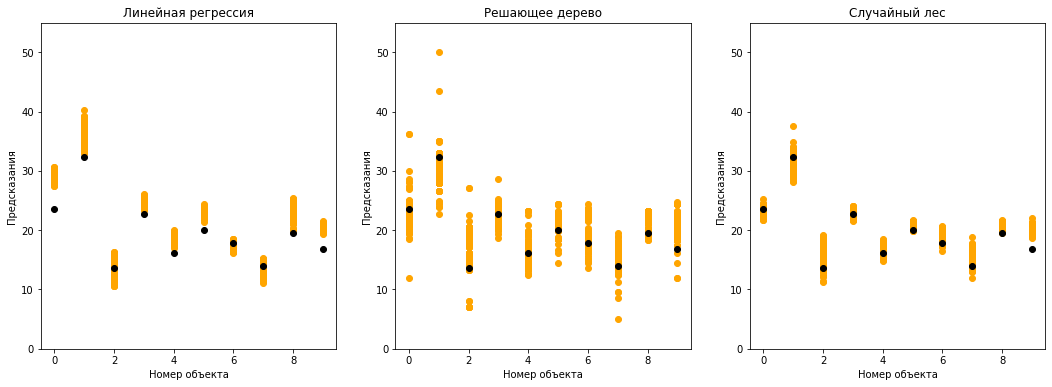

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plot_predictions(LinearRegression(), X ,y, title='Линейная регрессия', ax=axs[0])
plot_predictions(DecisionTreeRegressor(), X ,y, title='Решающее дерево', ax=axs[1])
plot_predictions(RandomForestRegressor(), X ,y, title='Случайный лес', ax=axs[2])

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Чем ближе сосредоточение оранжевых точек к чёрной, тем меньше смещение, чем меньше разброс вдоль y оранжевых точек, тем меньше разброс (кто бы мог подумать). У линейной регрессии видим, что довольно небольшой разброс, но смещение хромает, у решающего дерева наоборот - неплохое смещение, а вот разброс большой. У случайного леса, как и ожидалось, смещение как у одного дерева, а разброс сильно меньше. Всё как и обсуждалось ранее.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

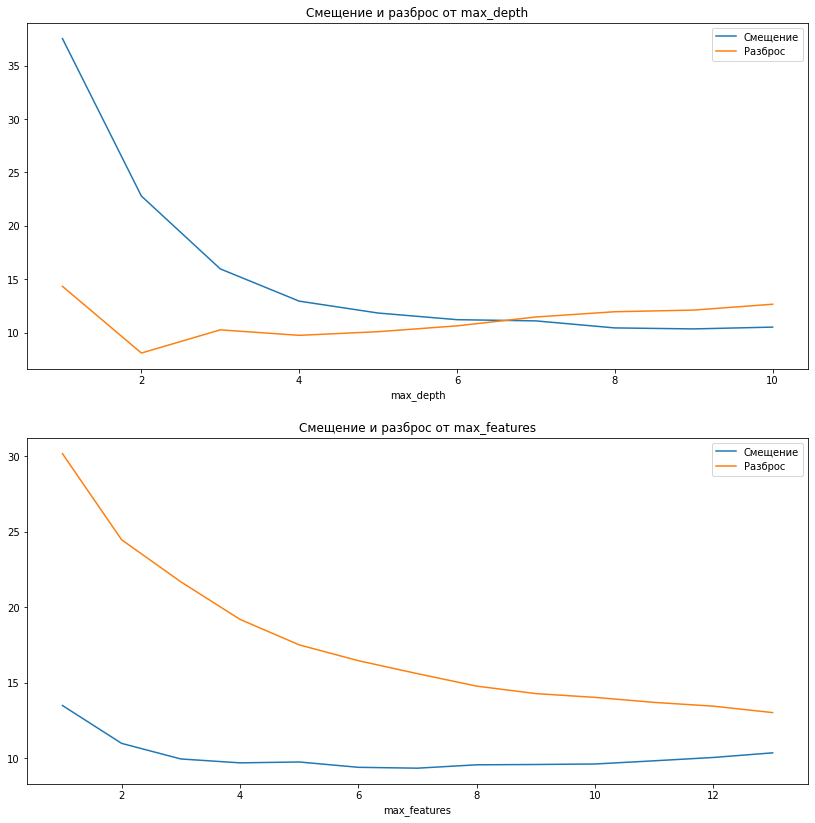

Wall time: 45.8 s


In [30]:
%%time
plt.figure(figsize=(14, 14))

variances = []
biases = []
for max_depth in range(1, 11):
    model = DecisionTreeRegressor(max_depth=max_depth)
    bias, variance, error = compute_biase_variance(model, X, y, num_runs=1000)
    biases.append(bias)
    variances.append(variance)

plt.subplot(2, 1, 1)
plt.plot(range(1, 11), biases, label='Смещение')
plt.title('Смещение и разброс от max_depth')
plt.plot(range(1, 11), variances, label='Разброс')
plt.xlabel('max_depth')

plt.legend()




variances = []
biases = []
for max_features in range(1, X.shape[1] + 1):
    model = DecisionTreeRegressor(max_features=max_features)
    bias, variance, error = compute_biase_variance(model, X, y, num_runs=1000)
    biases.append(bias)
    variances.append(variance)
    
plt.subplot(2, 1, 2)
plt.plot(range(1, X.shape[1] + 1), biases, label='Смещение')
plt.title('Смещение и разброс от max_features')

plt.plot(range(1, X.shape[1] + 1), variances, label='Разброс')
plt.xlabel('max_features')
plt.legend()

plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [67]:
from sklearn.ensemble import GradientBoostingRegressor

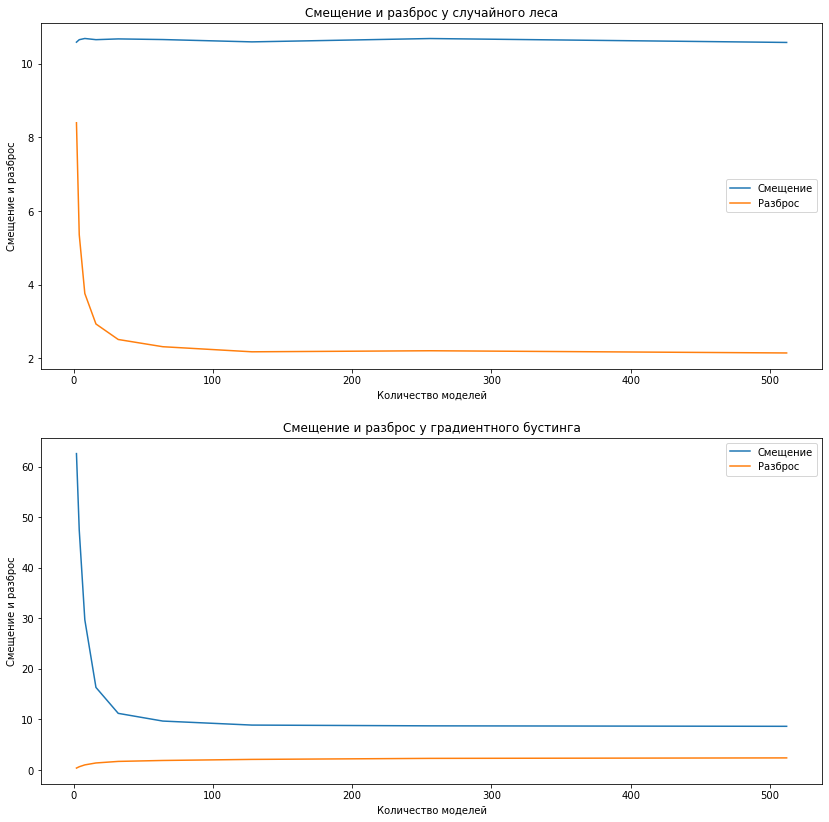

In [70]:
plt.figure(figsize=(14, 14))

rand_for_bias = []
rand_for_var = []
boost_bias = []
boost_var = []

for n_estimators in 2**np.arange(1, 10):
    model = RandomForestRegressor(n_estimators=n_estimators)
    bias, variance, error = compute_biase_variance(model, X, y)
    rand_for_bias.append(bias)
    rand_for_var.append(variance)
    
    model = GradientBoostingRegressor(n_estimators=n_estimators)
    bias, variance, error = compute_biase_variance(model, X, y)
    boost_bias.append(bias)
    boost_var.append(variance)
    
plt.subplot(2, 1, 1)
plt.title('Смещение и разброс у случайного леса')
plt.plot(2**np.arange(1, 10), rand_for_bias, label='Смещение')
plt.plot(2**np.arange(1, 10), rand_for_var, label='Разброс')
plt.xlabel('Количество моделей')
plt.ylabel('Смещение и разброс')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Смещение и разброс у градиентного бустинга')
plt.plot(2**np.arange(1, 10), boost_bias, label='Смещение')
plt.plot(2**np.arange(1, 10), boost_var, label='Разброс')
plt.xlabel('Количество моделей')
plt.ylabel('Смещение и разброс')
plt.legend()

plt.show()

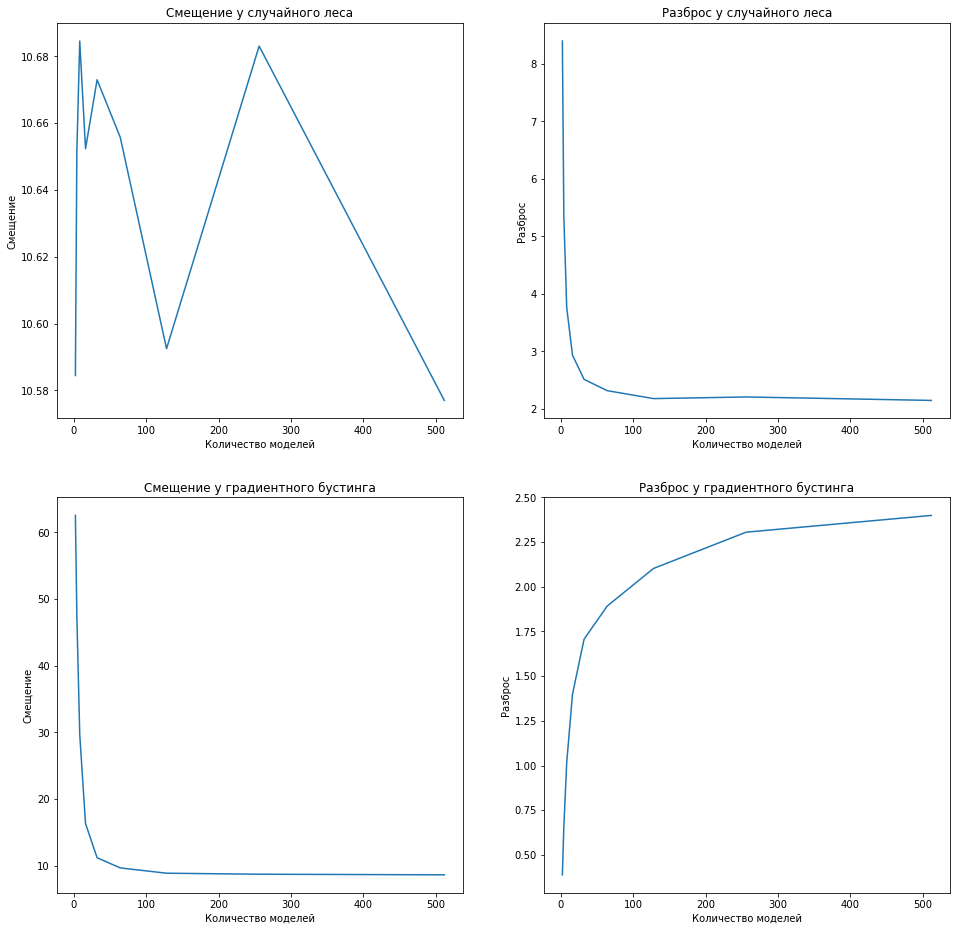

In [71]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.title('Смещение у случайного леса')
plt.plot(2**np.arange(1, 10), rand_for_bias)
plt.xlabel('Количество моделей')
plt.ylabel('Смещение')

plt.subplot(2, 2, 2)
plt.title('Разброс у случайного леса')
plt.plot(2**np.arange(1, 10), rand_for_var)
plt.xlabel('Количество моделей')
plt.ylabel('Разброс')

plt.subplot(2, 2, 3)
plt.title('Смещение у градиентного бустинга')
plt.plot(2**np.arange(1, 10), boost_bias)
plt.xlabel('Количество моделей')
plt.ylabel('Смещение')

plt.subplot(2, 2, 4)
plt.plot(2**np.arange(1, 10), boost_var)
plt.title('Разброс у градиентного бустинга')
plt.xlabel('Количество моделей')
plt.ylabel('Разброс')

plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ Как мы и обсуждали на лекциях, случайный лес - это бэггинг, а у бэггинга с ростом числа деревьем уменьшается разброс, но остаётся неизменной смещение, но разброс уменьшается лишь до определённого момента - пока новые модели не станут сильно коррелировать с предыдущими (ведь берём среднее из нескольких моделей). В градиентном бустинге же, наоборот, мы каждой новой моделью приводим ответ всё ближе к среднему, т.е. у нас уменьшается смещение, а разброс не уменьшается (в нашем случае даже немного увеличиваеься).

На графике зависимости смещания и разброса от глубины дерева видим, что чем больше глубина, тем меньше смещение, и это логично, ведь чем больше глубина, тем сильнее мы переобучаемся, а разброс в данном случае немного увеличивается. Что касается второго графика, логично, что при маленьком значении max_features у нас большой разброс, ведь при ответы дерева очень сильно зависят от того, какие именно признаки мы выберем для каждой вершины, а при увеличении количества выбираемых признаков этот фактор начинает невелировать. Смещение же сначала уменьшается, т.к. в начале мы брали слишком мало признаков в лист и недообучались, и ближе к концу начинает увеличивается, т.к. используюя все признаки в каждом листе мы можем переобучаться.

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.